
### **Chapter 3: Optimization Fundamentals**


In this chapter, we introduce optimization problems with and without constraints. First, we present unconstrained optimization problems and introduce several commonly used solvers, as well as their implementations in code. These methods will be tested across a variety of examples to illustrate their respective performance. Subsequently, we extend the discussion to constrained optimization problems. Utilizing CasADi’s symbolic framework, we store symbolic expressions and leverage its built-in solvers (e.g., qpOASES) to solve the problems and visualize the results. The theoretical foundations and implementation techniques introduced in this chapter will serve as the basis for subsequent chapters on iterative LQR and Model Predictive Control (MPC).

All the contents are summarized in the table below.  

<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 3 Exercise</th>
  </tr>

  <!-- Row group 1 -->
  <tr>
    <td rowspan="3">Unconstrained Optimization</td>
    <td>Example 1.1: Manual Unconstrained Optimization Solver Implementation</td>
  </tr>
  <tr>
    <td>Example 1.2~1.5: Using Implemented Solvers</td>
  </tr>
  <tr>
    <td>Example 1.6: Using Built-in Solvers</td>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="6">Constrained Optimization</td>
    <td>Example 2.1: Configuring Built-in Quadratic Programming Solvers</td>
  </tr>
  <tr>
    <td>Example 2.2: Solving QPs with Built-in Solvers</td>
  </tr>
  <tr>
    <td>Example 3.1: Manual Sequential QP Solver Implementation</td>
  </tr>
  <tr>
    <td>Example 3.2: Using Implemented SQP Solver for Nonlinear Programming</td>
  </tr>
  <tr>
    <td>Example 3.3: Configuring Built-in SQP Solvers for NLP</td>
  </tr>
  <tr>
    <td>Example 3.4: Using Built-in SQP Solver for NLP</td>
  </tr>

</table>

First, we need to import relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import casadi as ca
import time

<br>

### **Problem Definition:**

A generic optimization problem has the following form:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & f(\boldsymbol{x}) \\\\
\text{subject to} \quad & h_i(\boldsymbol{x}) = 0, \quad \forall i \in \{1, 2, \dots, N\}, \\\\
& g_j(\boldsymbol{x}) \leq 0, \quad \forall j \in \{1, 2, \dots, M\},
\end{aligned}
$$

where $ \boldsymbol{x} \in \mathbb{R}^n $ is the **optimization variable** of the problem, $ f : \mathbb{R}^n \mapsto \mathbb{R} $ is the **objective function**, and $ h_i : \mathbb{R}^n \mapsto \mathbb{R} $ and $ g_j : \mathbb{R}^n \mapsto \mathbb{R} $ are the *equality* and **inequality constraint functions**, respectively. The objective function and the constraint functions can be general nonlinear functions. In this chapter, we generally assume that $ f $, $ h_i $, and $ g_j $ are differentiable functions.

##### **Subclasses of optimization problems:**

   1\) **Unconstrained Optimization:**  A general optimization problem without any constraints is called an unconstrained optimization problem. In this case, the goal is to find a minimizer of the objective function without being restricted by any equality or inequality conditions.

   2\) **Linear Programming (LP):** An optimization problem is called a linear program if both the objective function and all the constraint functions are linear. Specifically, the objective is a linear function of the decision variables, and the feasible set is defined by linear equality and inequality constraints.

   3\) **Quadratic Programming (QP):** An optimization problem is called a quadratic program if the objective function is quadratic and the constraints are linear. That is, the objective function includes a quadratic term, while the equality and inequality constraints are affine functions of the decision variables.

   4\) **Nonlinear Programming (NLP):** A general optimization problem with at least one nonlinear function, either in the objective function, the inequality constraints, or the equality constraints, is called a nonlinear program. In a nonlinear program, the functions involved can be nonlinear, and solving such problems typically requires iterative numerical methods.

   5\) **Convex Programming:** An optimization problem with convex objective function and convex constraint functions. The important property of convex optimization problems is that every local minimum is also a global minimum. LPs and QPs are a special case of convex optimization problems. If any part of the problem is not convex, the problem is refered to as non-convex programming. 

<br>

----


### **Part (a): Unconstrained Optimization**

In this section, we introduce methods for solving unconstrained optimization problems. We begin by defining several common objective functions as testbeds for solvers. Afterwards we implement these solvers and evaluate their performance on the test problems and summarize the characteristics of different optimization methods.

<br>




#### **Objective Functions:**

As discussed above, unconstrained optimization primarily follows the form:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & f(\boldsymbol{x}) \,,
\end{aligned}
$$

where the objective function is typically selected from several standard forms. In the exercises of this chapter, we primarily use the following three objective functions as test cases:

1) **Quadratic Function:** A simple convex function used as a basic test case for optimization algorithms: 

$$
f(\boldsymbol{x}) = \left(\frac{x_0}{2}\right)^2 + x_1^2, \quad \boldsymbol{x}^* = [0, 0] \,.
$$

2) **Rosenbrock Function:** A non-convex function used to test the performance of optimization algorithms, characterized by a narrow, curved valley leading to the global minimum:

$$
f(\boldsymbol{x}) = (1 - x_0)^2 + 100 (x_1 - x_0^2)^2, \quad \boldsymbol{x}^* = [1, 1] \,.
$$

3) **Rastrigin Function:** A highly multimodal function used to test the ability of algorithms to escape local minima, combining a quadratic term with a cosine modulation:

$$
f(\boldsymbol{x}) = 20 + \left( x_0^2 - 10 \cos(2\pi x_0) \right) + \left( x_1^2 - 10 \cos(2\pi x_1) \right), \quad \boldsymbol{x}^* = [0, 0] \,.
$$


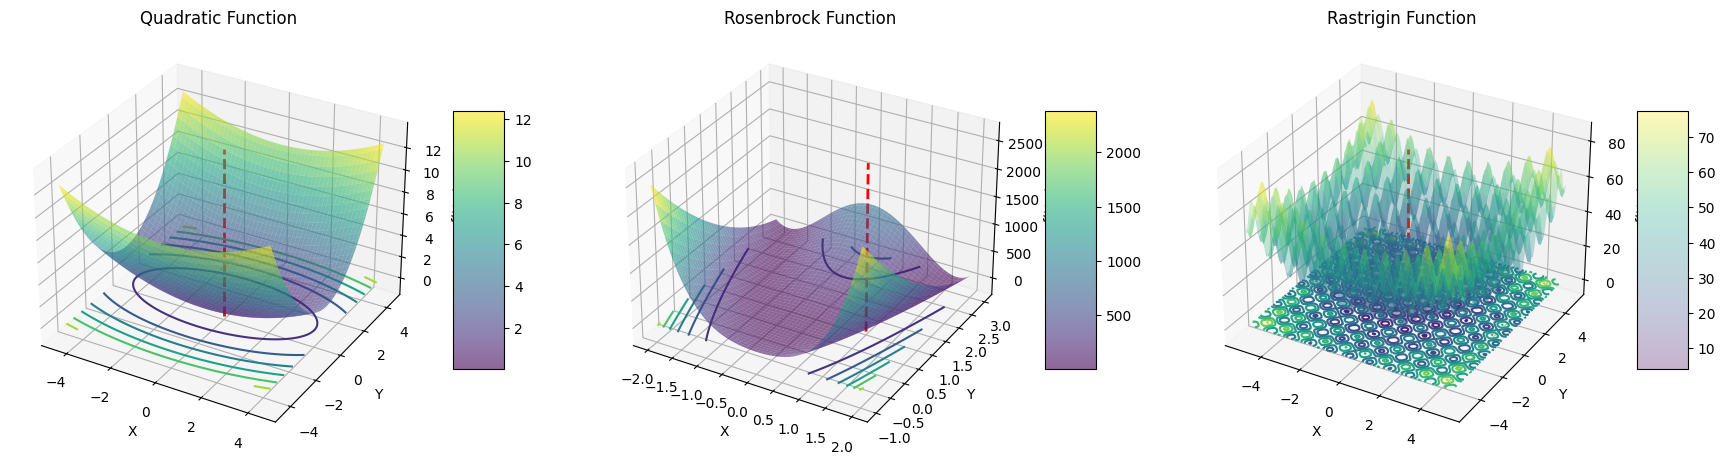

In [2]:
from mpl_toolkits.mplot3d import Axes3D

def quadratic(x):
    return 1/2*(x[0]**2/4 + x[1]**2)

quadratic_minimum = np.array([0.0, 0.0])

def rosenbrock(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

rosenbrock_minimum = np.array([1.0, 1.0])

def rastrigin_setup(pkg):
    def rastrigin(x):
        return 20 + (x[0]**2 - 10*pkg.cos(2*np.pi*x[0])) + (x[1]**2 - 10*pkg.cos(2*np.pi*x[1]))
    return rastrigin

rastrigin_minimum = np.array([0.0, 0.0])

def plot_function(func, x_range, y_range):
    x = np.linspace(x_range[0], x_range[1], 100)
    y = np.linspace(y_range[0], y_range[1], 100)
    X, Y = np.meshgrid(x, y)
    Z = func(np.array([X, Y]))
    return X, Y, Z

functions = [quadratic, rosenbrock, rastrigin_setup(np)]
minima = [quadratic_minimum, rosenbrock_minimum, rastrigin_minimum]

# Create 3D plots for each function
fig = plt.figure(figsize=(18, 6))

# Define appropriate ranges for each function
ranges = [
    [(-4.5, 4.5), (-4.5, 4.5)],       # Quadratic
    [(-2, 2), (-1, 3)],               # Rosenbrock
    [(-5.12, 5.12), (-5.12, 5.12)]    # Rastrigin
]

titles = ["Quadratic Function", "Rosenbrock Function", "Rastrigin Function"]

for i, (func, (x_range, y_range), title, minimum) in enumerate(zip(functions, ranges, titles, minima)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    X, Y, Z = plot_function(func, x_range, y_range)
    
    # Plot the global minimum as a red dashed line
    min_val = np.min(Z) - 0.1 * (np.max(Z) - np.min(Z))
    max_val = np.max(Z) + 0.1 * (np.max(Z) - np.min(Z))
    ax.plot([minimum[0], minimum[0]], [minimum[1], minimum[1]], [min_val, max_val], linestyle="--", 
            linewidth=2, color='red', label='Global minima of unconstrained optimization', zorder=1)

    if "Rastrigin" in title:
        # Increase transparency to better visualize the red dashed line
        alpha = 0.3
    else:
        alpha = 0.6

    # Create the surface plot
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=alpha, 
                          linewidth=0, antialiased=True, zorder=2)

    # Add a contour plot at the bottom
    cset = ax.contour(X, Y, Z, zdir='z', offset=np.min(Z), cmap='viridis')

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X,Y)')
    ax.set_title(title)
    
    # Add colorbar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout(pad=3.0)
plt.show()



#### **Algorithms for Unconstrained Optimization:**

The process of finding the optimal solution to an unconstrained optimization problem is typically iterative and each iteration can be divided into two main steps: 
 - Step 1: Determining the direction in which we can find an iterate with a lower function value. Common methods include gradient descent and Newton's method. 
 - Step 2: Determining how big of a step we can take in the chosen direction to reduce the function value at the next iterate.  Backtracking line search is one of the simplest and most widely used strategies.  

In the following, we will briefly introduce these algorithms.

##### **Gradient Descent**

Gradient descent (GD) is a first-order iterative optimization algorithm for finding the local minimum of a differentiable function.
At each iteration, it updates the current estimate by moving in the direction of the steepest descent, which is the negative gradient of the function at that point.

The update rule is given by:

$$
\boldsymbol{x}^{l+1} = \boldsymbol{x}^l - \alpha^l \nabla f(\boldsymbol{x}^l) \,,
$$

where:
   - $\boldsymbol{x}^l$ is the current iterate,
   - $\nabla f(\boldsymbol{x}^l)$ is the gradient of the objective function at $\boldsymbol{x}^l$,
   - $\alpha^l > 0$ is the step size (or learning rate), which can be determined via a line search strategy.

Gradient Descent guarantees convergence to a local minimum for nonlinear functions under appropriate conditions on the step size. However, it's also highly sensitive to the choice of step size—too small leads to slow convergence, while too large may cause divergence—and its inefficiency on ill-conditioned problems, where the optimization path can become highly zigzagged and slow.


##### **Newton's Method**

Newton's Method is a second-order optimization algorithm that uses both the gradient and the Hessian (second derivative) of the objective function to find a local minimum.
At each iteration, it updates the current estimate by moving along the Newton direction, which accounts for the local curvature of the function.

The update rule is given by:

$$
\boldsymbol{x}^{l+1} = \boldsymbol{x}^l - \alpha^l \left[\nabla^2 f(\boldsymbol{x}^l)\right]^{-1} \nabla f(\boldsymbol{x}^l) \,,
$$

where $\nabla^2 f(\boldsymbol{x}^l)$ is the Hessian matrix of the objective function at $\boldsymbol{x}^l$.


When the Hessian is positive definite and the initial guess is sufficiently close to the minimizer, Newton's Method achieves quadratic convergence, making it significantly faster than first-order methods like gradient descent near the solution.



##### **Line Search (Backtracking)**

Line search is a subroutine in optimization algorithms that determines an appropriate step size along a given search direction. The goal is to ensure sufficient decrease in the objective function while avoiding overly small steps. One of the most common and simple methods is **Backtracking Line Search**. It starts with a relatively large initial step size and repeatedly reduces it until a sufficient decrease condition (typically the **Armijo condition**) is satisfied. The pseudocode of the algorithm is shown below:

 - Start with an initial step size $\alpha = \alpha_0$ (typically $\alpha_0 \in \left(0,1\right)$).
 - Check whether the **Armijo condition** holds: $f(\boldsymbol{x}^l + \alpha p^l) \leq f(\boldsymbol{x}^l) + c \alpha \nabla f(\boldsymbol{x}^l)^T p^l$, where $c \in (0,1)$ is a small constant (e.g., $10^{-4}$).
 - If the condition is not satisfied, shrink the step size by a factor $\beta \in (0,1)$ (e.g., $\beta = 0.5$), that is, update $\alpha \leftarrow \beta \alpha$, and repeat the check.
 - Continue until the Armijo condition is satisfied.


<br>


#### **Example 1.1: Manual Unconstrained Optimization Solver Implementation**  

Based on the three algorithms introduced above, we now implement a solver for unconstrained optimization problems, which uses GD or Newton's method for finding the search direction, and applies the backtracking of the line search algorithm to determine a suitable step size. The implementation of the solver will follow the steps below:

&nbsp;&nbsp;&nbsp;&nbsp;1\) Initialize the algorithm parameters, including the starting point of the iteration $x_0$ and the line search parameters such as $\alpha_0$, $\beta$, and $c$;

&nbsp;&nbsp;&nbsp;&nbsp;2\) Use the CasADi symbolic system to define the symbolic variable $x$, and construct the expressions for the objective functions: Quadratic, Rosenbrock, and Rastrigin;

&nbsp;&nbsp;&nbsp;&nbsp;3\) Use automatic differentiation (Autodiff) to compute the Jacobian and Hessian of the objective function;

&nbsp;&nbsp;&nbsp;&nbsp;4\) Implement the main iteration loop:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; i\) Based on the precomputed Jacobian and Hessian information, determine the search direction using either Gradient Descent or Newton’s method;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ii\) Use backtracking line search starting from $\alpha_0$, progressively reducing the step size to find the largest 
$\alpha$ that satisfies the Armijo condition;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; iii\) Perform one iteration based on the search direction and step size, and check whether the convergence criterion is satisfied.

*Note that: for the symbolic framework, please check out this material https://web.casadi.org/docs/#document-symbolic*. *Section 3.3 shows how to define the symbolic variables.*  *Section 3.9 shows how to use the automatic differentiation to symbolically compute the Jacobian and Hessian.*  



In [3]:
class UnconstrOptimizer:
    def __init__(self, alpha_0 = 1.0, beta = 0.5, c = 1e-4):

        self.func_flag = 'quadratic'

        self.x_init = np.array([0.0, 0.0])

        self.solution_trajectory = []
        self.directions = []

        self.x = ca.MX.sym('x', 2)
        
        # Hyperparameters for line search
        self.alpha_0 = alpha_0
        self.beta = beta
        self.c = c

    def set_objective(self, func_type='quadratic'):
        self.func_flag = func_type

        if func_type == 'quadratic':
            expr = quadratic(self.x)
            self.global_minima = quadratic_minimum

        elif func_type == 'rosenbrock':
            expr = rosenbrock(self.x)
            self.global_minima = rosenbrock_minimum

        elif func_type == 'rastrigin':
            rastrigin = rastrigin_setup(ca)
            expr = rastrigin(self.x)
            self.global_minima = rastrigin_minimum

        else:
            raise ValueError("Unknown function type.")

        self.expr = expr
        self.f = ca.Function('f', [self.x], [expr])
        self.grad_f = ca.Function('grad_f', [self.x], [ca.gradient(expr, self.x)])
        self.hess_f = ca.Function('hess_f', [self.x], [ca.hessian(expr, self.x)[0]])

    def solve(self, x_init, method='gd', max_step=100, tol=1e-3):

        start_time = time.time()

        self.x_init = np.array(x_init, dtype=np.float64)
        self.method = method
        self.tol = tol
        self.max_step = max_step

        self.solution_trajectory = [self.x_init.copy()]
        self.directions = []

        x_val = np.copy(self.x_init)

        for iter in range(self.max_step):
            grad = self.grad_f(x_val).full().flatten()
            hess = self.hess_f(x_val).full()

            # Search direction
            if self.method == 'gd':
                direction = -grad

            elif self.method == 'newton':
                direction = -np.linalg.solve(hess + 1e-8*np.eye(2), grad)
                
            else:
                raise ValueError("Method must be 'gd' or 'newton'")

            descent = grad @ direction
            if abs(descent) < self.tol:
                print(f"Optimization completed in {iter} steps, converging to a local minimum.")
                break

            # Line search (backtracking)
            alpha = self.alpha_0
            f0 = float(self.f(x_val))
            while float(self.f(x_val + alpha * direction)) > f0 + self.c * alpha * descent:
                alpha *= self.beta
            
            # Update
            x_val = x_val + alpha * direction
            self.solution_trajectory.append(x_val.copy())
            self.directions.append(direction.copy())
        
        else:
            print(f"{max_step} steps passed, still not converging to a local minimum.")

        total_time = time.time() - start_time
        
        print(f"Total computation time: {total_time} s, average computation time per cycle: {total_time/iter} s.")

    def plot_results(self):
        sol = np.array(self.solution_trajectory)

        x_max = max(5, np.max(sol[:, 0]))
        x_min = min(-5, np.min(sol[:, 0]))
        y_max = max(5, np.max(sol[:, 1]))
        y_min = min(-5, np.min(sol[:, 1]))

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        # Global Optima
        ax.plot(self.global_minima[0], self.global_minima[1], marker='*', markersize=15,
                color='red', label='Global minima of unconstrained optimization', zorder=10)

        # Optimization Trajectory
        ax.plot(sol[:, 0], sol[:, 1], marker='d', markersize=4,
                color='orange', label='Trajectory', zorder=10)
        ax.plot(sol[0, 0], sol[0, 1], color='darkorange', marker='o', markersize=8, label='Initial guess', zorder=11)
        ax.plot(sol[-1, 0], sol[-1, 1], 'gs', label='Optimal solution from solver', zorder=11)

        ax.set_title(f'Optimization Trajectory with {self.func_flag.capitalize()} Function')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.5)
        plt.show()



<br>

##### **Example 1.2: Using Implemented Solvers**

Starting with a simple scenario, we first attempt to solve the quadratic objective function using the above unconstrained optimization algorithms. The quadratic function is a simple convex function, and thus can be directly optimized using Gradient Descent. The steps are as follows:

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`(the default parameter settings can be used directly);

2\) Set the objective function to be `quadratic`;

3\) Call solving loop function, set the direction searching method to be `gd` and other solver parameters as follows;

4\) Plot the result and observe the optimization trajectory.



Optimization completed in 12 steps, converging to a local minimum.
Total computation time: 0.003888845443725586 s, average computation time per cycle: 0.00032407045364379883 s.


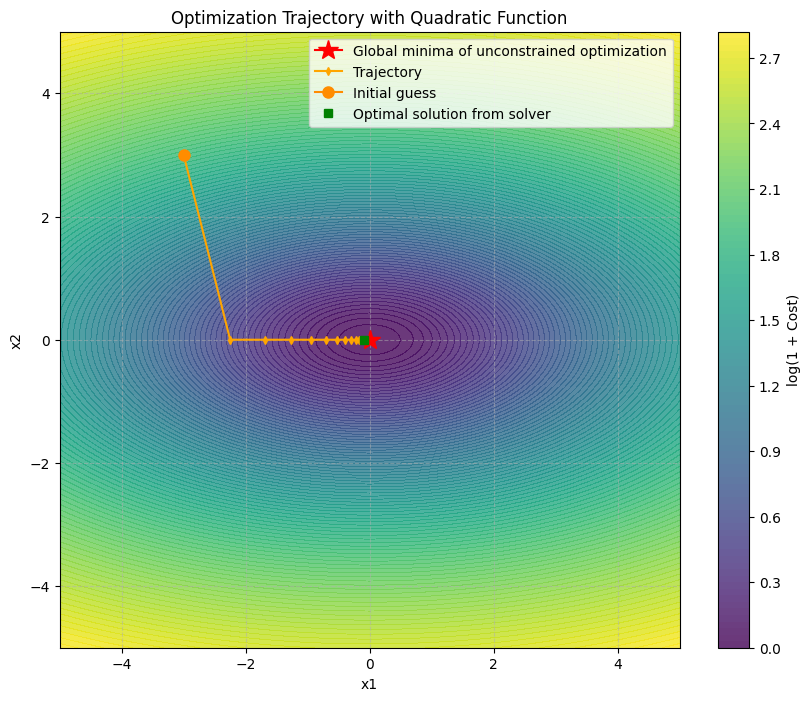

In [4]:
# Quadratic cost + GD solver
opt = UnconstrOptimizer()
opt.set_objective('quadratic')
opt.solve(x_init=[-3, 3], method='gd', max_step=100)
opt.plot_results()


**Conclusion:**

This figure illustrates the performance of GD in optimizing a quadratic objective function. Since quadratic functions are strongly convex with smooth curvature, GD ensures global convergence and follows a stable descent path. The trajectory steadily approaches the global minimum at the origin, demonstrating GD’s efficiency, especially when the Hessian has a well-conditioned structure. The log-scaled contour lines highlight the rapid cost reduction in early iterations and the slower convergence near the minimum, highlighting the importance of step size adaptation strategies like backtracking.

<br>

##### **Example 1.3: Using Implemented Solver to Optimize the Rosenbrock Function**

Now let us consider a more challenging scenario by choosing the Rosenbrock function as the objective. Its global minimum lies at $[1.0,1.0]$, but the function is notoriously difficult to optimize due to its narrow, curved valley and steep walls, which can easily mislead simple gradient-based methods. We will attempt to optimize it using GD and observe the resulting behavior.

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`;

2\) Set the objective function to be `rosenbrock`;

3\) Call solving loop function, set the direction searching method to be `gd` and the maximal step number to be 2000~5000;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Hint: you may try the maximal step number for both lower and upper limit, which will lead to different optimization results*

4\) Plot the result and observe the optimization trajectory.

Optimization completed in 4003 steps, converging to a local minimum.
Total computation time: 0.8720312118530273 s, average computation time per cycle: 0.00021784441964852044 s.


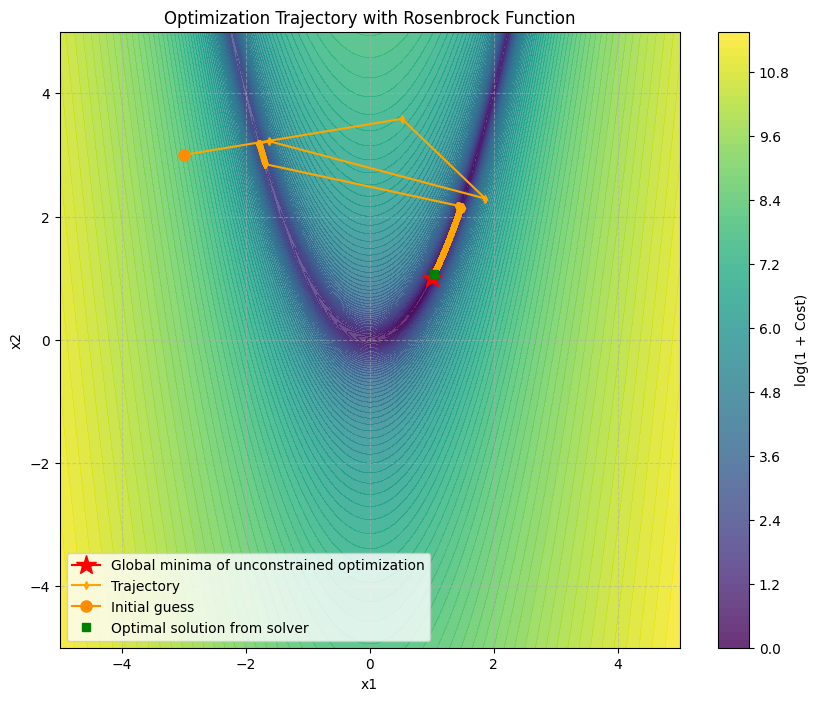

In [5]:
# Rosenbrock cost + GD solver
opt = UnconstrOptimizer()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3.0, 3.0], method='gd', max_step=5000)  # max_step: 2000 TO 5000
opt.plot_results()

**Conclusion:**

This figure shows the optimization trajectory of gradient descent applied to the Rosenbrock function. Due to the function’s narrow, curved valley and sharp gradients across directions, GD initially struggles to follow the optimal path and exhibits zigzag behavior as it gradually aligns with the valley floor. The trajectory eventually begins to converge toward the global minimum, but the progress is much slower compared to optimizing a quadratic function. **This highlights the limitations of GD in ill-conditioned landscapes, where the local curvature causes inefficient updates unless the step size is carefully controlled.** With around 5000 iterations, convergence to the minimum can be achieved, but at a significantly higher computational cost.

<br>

As an alternative approach to mitigate the zigzagging behavior often observed in GD, **we can use a smaller initial step size**. This can be achieved by adjusting the initial step length parameter $\alpha_0$ in the backtracking line search algorithm. In our current implementation, the default value of $\alpha_0$ is 1. We now change it to 0.1 and rerun the optimization algorithm to observe how the convergence behavior is affected.

Optimization completed in 4468 steps, converging to a local minimum.
Total computation time: 0.7117311954498291 s, average computation time per cycle: 0.00015929525412932612 s.


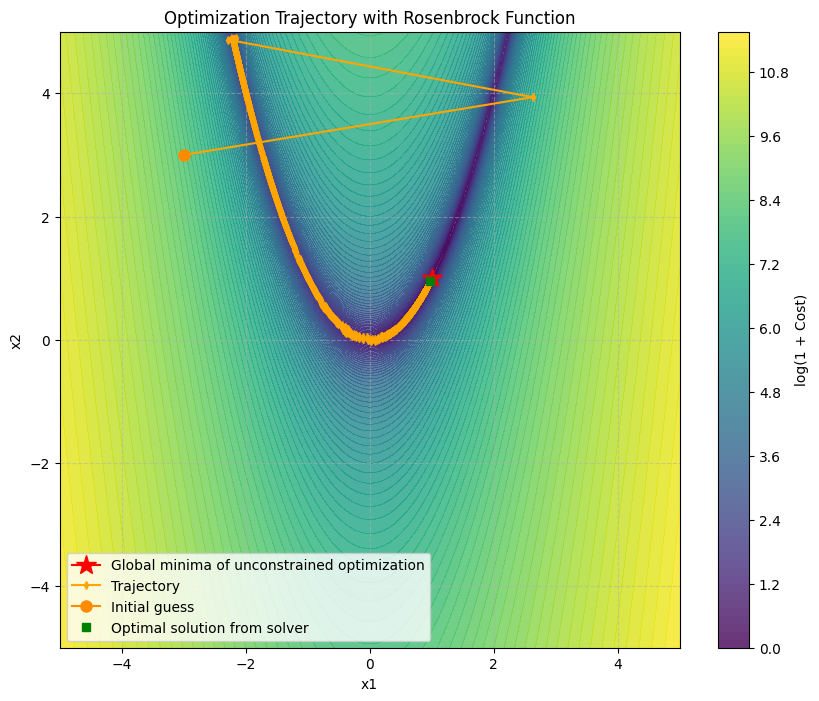

In [6]:
# Smaller intial step size for backtracking
alpha_0 = 0.1

# Rosenbrock cost + GD solver
opt = UnconstrOptimizer(alpha_0=alpha_0)
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3.0, 3.0], method='gd', max_step=5000)  # max_step: 2000 TO 5000
opt.plot_results()

**Conclusion:**

From the results, we observe that after reducing the step size, the optimization trajectory becomes much smoother and aligns more closely with the curved valley of the Rosenbrock function, indicating improved stability and reduced oscillations. **However, this comes at the cost of requiring more iterations to reach the optimum, which implies increased computational overhead.**


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Line Search**

To better understand the impact of line search on optimization performance, here you are encouraged to:

- Experiment with the different hyperparameter configurations in backtracking line search, namely $\alpha_0$, $\beta$, and $c$;

- Implement your own line search stopping condition. In addition to the Armijo condition, another commonly used criterion is the Strong Wolfe condition (see [Wolfe conditions](https://en.wikipedia.org/wiki/Wolfe_conditions)).

</blockquote>

##### **Example 1.4: Using Newton's Method to Optimize the Rosenbrock Function**

Given the poor performance of GD on the Rosenbrock function, we now attempt to optimize it using Newton’s method. Compared to GD, Newton’s method leverages second-order curvature information, allowing it to take more informed steps and converge faster near the optimum, especially in ill-conditioned landscapes.

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`;

2\) Set the objective function to be `rosenbrock`;

3\) Call solving loop function, set the direction searching method to be `newton` and other solver parameters as follows;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Hint: now you can use a much smaller number for the maximal step number.*

4\) Plot the result and observe the optimization trajectory.

Optimization completed in 26 steps, converging to a local minimum.
Total computation time: 0.009157657623291016 s, average computation time per cycle: 0.0003522176008958083 s.


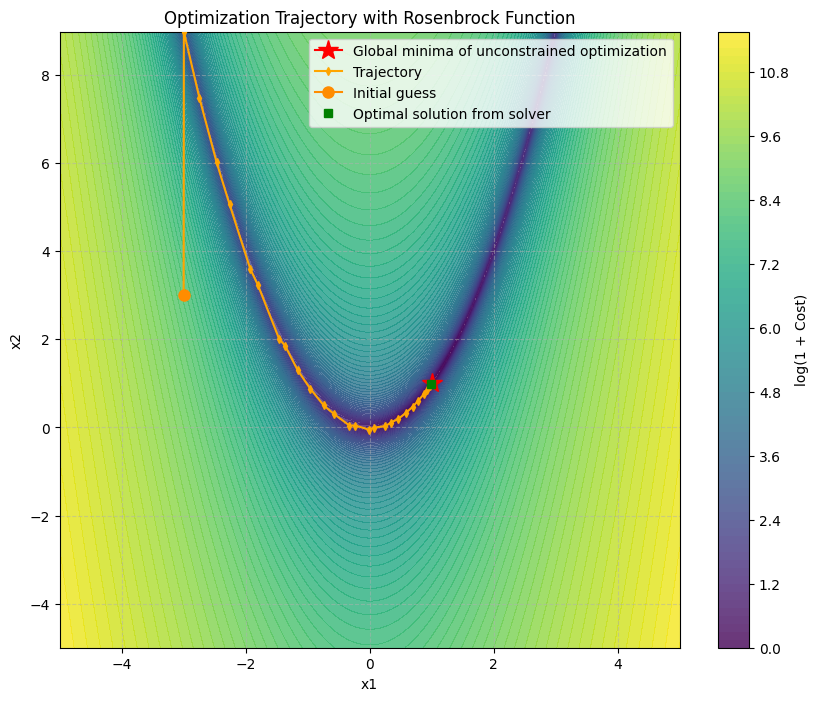

In [7]:
# Rosenbrock cost + newton solver
opt = UnconstrOptimizer()
opt.set_objective('rosenbrock')
opt.solve(x_init=[-3, 3], method='newton', max_step=100)
opt.plot_results()


**Conclusion:**

This figure shows the optimization trajectory of Newton's method applied to the Rosenbrock function. Unlike Gradient Descent, Newton’s method successfully converges to the global optimum at $[1.0,1.0]$ in fewer than 50 iterations, demonstrating significantly higher efficiency. The trajectory closely follows the curved valley, highlighting **Newton's ability to incorporate second-order curvature information for better step directions**, especially in narrow and ill-conditioned landscapes. This result underscores the strength of Newton’s method in adapting to the local geometry of complex objective functions.

However, Newton's method also has notable drawbacks when comparing with GD: **it requires computing and inverting the Hessian matrix, which can be computationally expensive and numerically unstable**, especially in high-dimensional problems. Therefore, in practical applications, the choice of direction search algorithm should be guided by the structure and properties of the specific objective function.

<br>

##### **Example 1.5: Using Newton's Method to Optimize the Rastrigin Function**

Now let us consider a more complex scenario as the testbed for Newton’s method: the Rastrigin function, which is highly non-convex and characterized by a large number of regularly spaced local minima, making it particularly challenging for local optimization methods that rely on gradient and curvature information.

1\) Instantiate the unconstrained solver class `UnconstrOptimizer`;

2\) Set the objective function to be `rastrigin`;

3\) Call solving loop function, set the direction searching method to be `newton` and other solver parameters as follows;

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Hint: you may try different initializations, which will lead to different optimization results. Recommended initial states to test are:*

$$
\boldsymbol{x}_0^{(1)} = \begin{bmatrix}-0.8\\3.2\end{bmatrix}, 
\quad \boldsymbol{x}_0^{(2)} = \begin{bmatrix}-0.7\\3.3\end{bmatrix}, 
\quad \boldsymbol{x}_0^{(3)} = \begin{bmatrix}-0.3\\0.3\end{bmatrix}, 
\quad \boldsymbol{x}_0^{(4)} = \begin{bmatrix}-0.2\\0.2\end{bmatrix}
$$

4\) Plot the result and observe the optimization trajectory.

Optimization completed in 3 steps, converging to a local minimum.
Total computation time: 0.0018343925476074219 s, average computation time per cycle: 0.0006114641825358073 s.


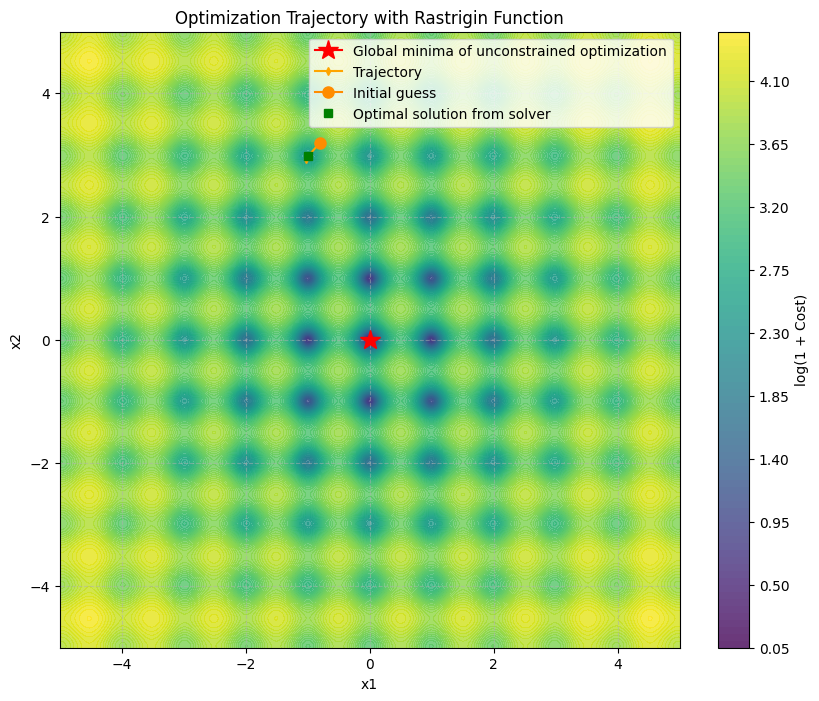

In [8]:
# Rastrigin cost + newton solver
opt = UnconstrOptimizer()
opt.set_objective('rastrigin')
opt.solve(x_init=[-0.8, 3.2], method='newton', max_step=100) # x_init: [-0.8, 3.2] OR [-0.7, 3.3] OR [-0.3, 0.3] OR [-0.2, 0.2]
opt.plot_results()

**Conclusion:**

The experimental results show that when applying Newton’s method to non-convex objective functions, the optimization trajectory is prone to getting trapped in local minima. Moreover, whether the algorithm converges to a global or local optimum largely depends on the initial starting point—Newton’s method typically converges to the nearest stationary point. **This highlights the importance of initialization: the quality of the final solution is highly sensitive to where the optimization begins.**


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Go Beyond Local Minima**

Since Newton’s method is highly sensitive to initialization, you are encouraged to **think creatively about how to increase the chances of reaching the global optimum**. Consider experimenting with multiple starting points, designing smarter initialization heuristics, or combining global exploration with local refinement. The goal is not just to run the algorithm, but to strategize around it—can you develop a method that consistently avoids poor local solutions?

</blockquote>

<br>

##### **Example 1.6: Using Built-in Solvers**

While the previous section focused on building unconstrained optimization solvers from scratch using backtracking line search and descent directions (e.g., gradient or Newton-based), this was primarily intended to illustrate the fundamental ideas behind iterative optimization algorithms.

In practice, one can take advantage of robust and efficient solvers available in modern libraries. In Python, the `scipy.optimize.minimize function` offers a range of algorithms for unconstrained and constrained problems. Below are some commonly used methods:

- `BFGS` (Broyden–Fletcher–Goldfarb–Shanno): A quasi-Newton method that approximates the Hessian matrix using only gradient information. It is efficient for medium-scale problems and does not require computing second derivatives.

- `L-BFGS-B` (Limited-memory BFGS with Box constraints): A memory-efficient version of BFGS that is suitable for large-scale problems. It allows simple bound constraints on variables, making it useful for problems that are “mostly” unconstrained but still have variable bounds.

- `Newton-CG` (Newton-Conjugate Gradient): A Newton-type method that uses a conjugate gradient approach to compute the Newton step without forming the full Hessian. It is effective when the Hessian-vector product can be computed efficiently.

- `trust-constr` (Trust Region Constrained): A versatile trust-region method that handles both equality and inequality constraints. For unconstrained problems, it behaves similarly to other second-order trust-region solvers and is suitable when higher accuracy is needed.

To apply these solvers, users typically need to provide:

- **Objective function**: a callable function returning a scalar value.

- **Initial guess**: starting point for the optimization.

- **(Optional)**: gradient (Jacobian), Hessian, or Hessian-vector product, depending on the solver.

- **(Optional)**: method-specific parameters such as maximum iterations, tolerances, etc.

For example, using `scipy.optimize.minimize`:

Total computation time: 0.001641988754272461 sec.


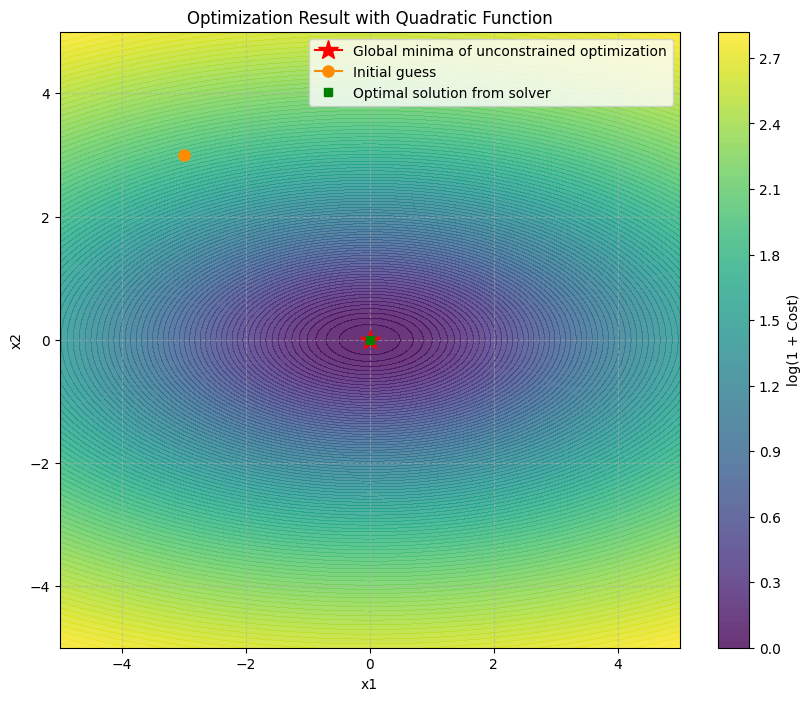

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

objective = 'quadratic' # 'quadratic' OR 'rosenbrock' OR 'rastrigin'

rastrigin = rastrigin_setup(np)

# Define the objective function
def f(x):
    if objective == 'quadratic':
        return quadratic(x)
    elif objective == 'rosenbrock':
        return rosenbrock(x)
    elif objective == 'rastrigin':
        return rastrigin(x)

# Set global minima for plotting
if objective == 'quadratic':
    global_minima = quadratic_minimum
elif objective == 'rosenbrock':
    global_minima = rosenbrock_minimum
elif objective == 'rastrigin':
    global_minima = rastrigin_minimum

start_time = time.time()
    
# Initial guess
# as before, you are encouraged to play around the initial guess to see the influence
x0 = [-3, 3]

# Run optimization
res = minimize(f, x0, method='BFGS')

print(f"Total computation time: {time.time() - start_time} sec.")

# Create a plot for result visualization
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f([X[i, j], Y[i, j]])

Z_log = np.log1p(Z)  # for better contrast

fig, ax = plt.subplots(figsize=(10, 8))
CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
cbar = plt.colorbar(CS, ax=ax)
cbar.set_label('log(1 + Cost)')

# Global minimum
ax.plot(global_minima[0], global_minima[1], marker='*', markersize=15,
        color='red', label='Global minima of unconstrained optimization', zorder=10)

# Initial and final solutions
ax.plot(x0[0], x0[1], color='darkorange', marker='o', markersize=8, label='Initial guess', zorder=11)
ax.plot(res.x[0], res.x[1], 'gs', label='Optimal solution from solver', zorder=11)

ax.set_title(f'Optimization Result with {objective.capitalize()} Function')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
plt.show()


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Parameters in `scipy.optimize.minimize` with BFGS**

When using the `'BFGS'` method in `scipy.optimize.minimize`, a number of optional parameters can be provided to control optimization behavior and diagnostics (see https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html#optimize-minimize-bfgs). These are passed via the `options` dictionary:

- `maxiter`: Sets the **maximum number of iterations** (default: `None`, i.e., algorithm-dependent).

- `gtol`: The **gradient norm tolerance** for convergence. Optimization terminates when $\|\nabla f(x)\|_\infty < \texttt{gtol}$. Default: `1e-5`.

- `disp`: Whether to **print convergence messages** (`True` or `False`).

- `return_all`: If `True`, returns a list of all iterates in `res.allvecs`.

These can be passed using the `options` keyword argument in `minimize()`.

**Example:**

```python

        res = minimize(f, x0, method='BFGS', options={
            "disp": True,
            "maxiter": 100,
            "gtol": 1e-6,
            "return_all": True
        })
```

*Note that: jac=... can also be specified to provide the gradient of the objective function. The Hessian is not required and will be approximated internally by the BFGS update.*

</blockquote> 

<br>

----

### **Part (b): Constrained Optimization**

As introduced above, a constrained optimization problem has the form:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & f(\boldsymbol{x}) \\
\text{subject to} \quad & h_i(\boldsymbol{x}) = 0, \quad \forall i \in \{1, 2, \dots, N\}, \\
& g_j(\boldsymbol{x}) \leq 0, \quad \forall j \in \{1, 2, \dots, M\} \,.
\end{aligned}
$$

To solve such problems, the **Karush-Kuhn-Tucker (KKT) conditions** provide necessary conditions for optimality under regularity assumptions. The idea is to construct the **Lagrangian**:

$$
\Lambda(\boldsymbol{x}, \lambda, \mu) = f(\boldsymbol{x}) + \sum_{i=1}^N \lambda_i h_i(\boldsymbol{x}) + \sum_{j=1}^M \mu_j g_j(\boldsymbol{x}),
$$

and then enforce the following **KKT conditions**:

- **Stationarity**:
   $$
   \nabla_x \Lambda(\boldsymbol{x}^*, \lambda^*, \mu^*) = 0
   $$

- **Primal feasibility**:
   $$
   h_i(\boldsymbol{x}^*) = 0, \quad \forall i, \qquad g_j(\boldsymbol{x}^*) \leq 0, \quad \forall j
   $$

- **Dual feasibility**:
   $$
   \mu_j^* \geq 0, \quad \forall j
   $$

- **Complementary slackness**:
   $$
   \mu_j^* \cdot g_j(\boldsymbol{x}^*) = 0, \quad \forall j
   $$

Together, these conditions characterize candidate optimal solutions for constrained nonlinear programming problems.

Although the KKT conditions characterize optimal solutions for constrained optimization problems, they cannot be directly used to solve QP or NLP problems without additional numerical strategies. Specifically:

- **KKT conditions are not algorithms** — they provide necessary optimality conditions but do not specify how to compute the solution.

- **The KKT system itself can be complex** — even in QP problems, solving the KKT conditions leads to a linear system with complementarity constraints, which requires specialized numerical methods.

- **In Sequential QP (an approach to solve NLP), KKT conditions are approximated iteratively** — each sequential QP (SQP) iteration constructs a local QP subproblem using linearized constraints and a quadratic approximation of the cost, and solving this subproblem involves solving the KKT system numerically.

- **Modern solvers encapsulate the KKT logic internally** — tools like `qpOASES`, `OSQP`, and `Ipopt` handle all KKT-related computations, allowing users to focus on modeling rather than solver internals.

Thus, while the KKT framework underlies QP and SQP theory, practical solution requires converting the conditions into structured numerical subproblems and solving them with dedicated algorithms and solvers, which we will introduce in the following sections.

<br>

#### **Example 2.1: Configuring Built-in Quadratic Programming Solvers**  


Let us first consider a simple variant of the nonlinear programming (NLP) problem: the quadratic programming (QP) problem. A QP problem is defined as an optimization problem where the objective function is quadratic and the constraints are linear. It follows the standard form:

\begin{equation}
\begin{aligned}
\min_{\boldsymbol{x}} \quad & \frac{1}{2} \boldsymbol{x}^\top \bm{H} \boldsymbol{x} + \bm{q}^\top \boldsymbol{x} \\
\text{s.t.} \quad & \bm{A}_{\text{eq}} \boldsymbol{x} = \bm{b}_{\text{eq}}\\
                  & \bm{A}_{\text{ineq}} \boldsymbol{x} \leq \bm{b}_{\text{ineq}}
\end{aligned}
\end{equation}

Here, $\boldsymbol{H} \in \mathbb{R}^{n \times n}$ is a symmetric matrix defining the curvature of the cost, and $\boldsymbol{g} \in \mathbb{R}^n$ defines the linear component of the cost. The matrices $\boldsymbol{A}_{\text{eq}} \in \mathbb{R}^{N \times n}, \boldsymbol{b}_{\text{eq}} \in \mathbb{R}^{N}, \boldsymbol{A}_{\text{ineq}}\in \mathbb{R}^{M \times n},$ and $\boldsymbol{b}_{\text{ineq}} \in \mathbb{R}^{M}$ describe the equality and inequality constraints, respectively.

Quadratic programming (QP) problems can be solved by deriving and solving the associated Karush-Kuhn-Tucker (KKT) conditions. With the advancement of symbolic and numerical computing tools, modern QP solvers such as **OSQP** and **qpOASES** have automated this process. These solvers internally construct and solve the KKT system, allowing users to simply specify the objective function, constraints, and relevant optimization parameters through a well-defined interface.

In this section, we choose **qpOASES** as the QP solver to demonstrate how to configure and use its interface for solving QP problems. It is worth noting that qpOASES is natively supported by CasADi, which allows it to be directly specified as the underlying QP solver within a CasADi-based optimization setup without requiring any separate package installation. The procedure follows the steps below:

&nbsp;&nbsp;&nbsp;&nbsp;**1\) Formulate the QP problem from external.** The standard form of a QP problem supported by CasADi is:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & \frac{1}{2} \boldsymbol{x}^\top \boldsymbol{H} \boldsymbol{x} + \boldsymbol{q}^\top \boldsymbol{x} \\
\text{s.t.} \quad & \boldsymbol{l}_{\text{bg}} \leq \boldsymbol{A} \boldsymbol{x} \leq \boldsymbol{u}_{\text{bg}},
\end{aligned}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $\boldsymbol{A} =
\begin{bmatrix}
\boldsymbol{A}_{\text{eq}}\\
\boldsymbol{A}_{\text{ineq}}
\end{bmatrix}$ defines linear constraints (inkl. equality and inequality constraints) with lower and upper bounds $\boldsymbol{l}_{\text{bg}} = \begin{bmatrix}
\boldsymbol{b}_{\text{eq}} \\
-\infty
\end{bmatrix}, \quad
\boldsymbol{u}_{\text{bg}} = \begin{bmatrix}
\boldsymbol{b}_{\text{eq}} \\
\boldsymbol{b}_{\text{ineq}}
\end{bmatrix}$.

&nbsp;&nbsp;&nbsp;&nbsp;**2\) Define the QP structure in CasADi.** To pass the QP into CasADi, you need to define a dictionary containing:

$$
\texttt{qp = \{x: }\boldsymbol{x}\texttt{, f: }f(\boldsymbol{x})\texttt{, g: }g(\boldsymbol{x})\texttt{\}},
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $f(\boldsymbol{x})=\frac{1}{2} \boldsymbol{x}^\top \boldsymbol{H} \boldsymbol{x} + \boldsymbol{q}^\top \boldsymbol{x} $ is the quadratic objective and $g(\boldsymbol{x}) = \boldsymbol{A} \boldsymbol{x}$ represents the constraint expressions.


&nbsp;&nbsp;&nbsp;&nbsp;**3\) Configure and call the solver.** Create and configure the solver using:

$$
\texttt{solver = nlpsol("solver", "qpoases", qp)},
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;and called with the necessary constraint bounds and initial guess:

$$
\texttt{sol = solver(x0, lbg, ubg)}.
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The optimal solution can then be extracted from the returned dictionary.

*Note that: for details on the QP solver in CasADi, check out https://web.casadi.org/docs/#quadratic-programming*  




In [10]:
class QPOptimizer:
    def __init__(self):
        self.x = ca.MX.sym('x', 2)
        self.set_objective()
        self.eq_params = None
        self.ineq_params = None
        self.optimum = None
        self.x_init=None

    def set_objective(self):
        self.expr = 0.5 * (self.x[0]**2 / 4 + self.x[1]**2)
        self.f = ca.Function('f', [self.x], [self.expr])
        self.global_minima = np.array([0.0, 0.0])

    def set_constraints(self, eq_params=None, ineq_params=None):
        self.eq_params = eq_params
        self.ineq_params = ineq_params

    def solve(self, x_init=[0.0, 0.0]):
        
        start_time = time.time()

        self.x_init = x_init

        A_list = []
        lba = []
        uba = []

        if self.eq_params:
            # a x_0 + b x_1 + c = 0
            a, b, c = self.eq_params
            A_list.append(np.array([[a, b]]))
            lba.append(-c)
            uba.append(-c)

        if self.ineq_params:
            # a x_0 + b x_1 + c <= 0
            a, b, c = self.ineq_params
            A_list.append(np.array([[a, b]]))
            lba.append(-np.inf)
            uba.append(-c)

        A_total = np.vstack(A_list) if A_list else np.zeros((0, 2))
        lba = np.array(lba)
        uba = np.array(uba)

        qp = {
            'x': self.x,
            'f': self.expr,
            'g': ca.mtimes(ca.DM(A_total), self.x)
        }
        
        solver = ca.qpsol('solver', 'qpoases', qp)

        sol = solver(x0=x_init, lbg=lba, ubg=uba)

        self.optimum = sol['x'].full().flatten()

        print(f"Total computation time: {time.time() - start_time} s.")
        
        return self.optimum.tolist()

    def plot_results(self):
        x_max = 2.5
        x_min = -2.5
        y_max = 2.5
        y_min = -2.5

        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        if self.eq_params:
            a, b, c = self.eq_params
            if b != 0:
                x_eq = np.linspace(x_min, x_max, 400)
                y_eq = (-a * x_eq - c) / b
                ax.plot(x_eq, y_eq, 'k--', linewidth=2, label='Equality Constraint')
            else:
                x_eq = -c / a
                ax.axvline(x_eq, color='k', linestyle='--', linewidth=2, label='Equality Constraint')

        if self.ineq_params:
            a, b, c = self.ineq_params
            if b != 0:
                x_ineq = np.linspace(x_min, x_max, 400)
                y_ineq = (-a * x_ineq - c) / b
                ax.plot(x_ineq, y_ineq, 'b-', linewidth=2, label='Inequality constraint')
                ax.fill_between(x_ineq, y_ineq, y_max, color='blue', alpha=0.3)
            else:
                x_ineq = -c / a
                ax.axvline(x_ineq, color='b', linestyle='-', linewidth=2, label='Inequality constraint')
                if a > 0:
                    ax.axvspan(x_min, x_ineq, color='blue', alpha=0.1)
                else:
                    ax.axvspan(x_ineq, x_max, color='blue', alpha=0.1)

        if self.optimum is not None:
            ax.plot(self.optimum[0], self.optimum[1], 'gs', markersize=10, label='Optimal solution from QP solver', zorder=11)

        ax.plot(self.x_init[0], self.x_init[1], color='darkorange', marker='o', markersize=8, label='Initial guess', zorder=11)

        ax.plot(self.global_minima[0], self.global_minima[1], '*', color='red', markersize=15, label='Global minima of unconstrained optimization')
        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("Constrained Optimization Result (qpOASES)")
        ax.grid(True)
        ax.legend()
        plt.show()


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Parameters in QP solver configuration**

A number of solver options can be specified when using **qpOASES** in CasADi to fine-tune the optimization behavior (see https://web.casadi.org/api/internal/d5/d43/classcasadi_1_1QpoasesInterface.html). The most relevant parameters include:

- `printLevel`: Controls the verbosity of solver output. Accepts values such as `"none"`, `"low"`, `"medium"`, or `"high"`.

- `maxIterations`: Sets the maximum number of iterations for the solver (default: 100).

- `terminationTolerance`: Sets the accuracy required for convergence (default: 1e-5).

- `boundTolerance`: Tolerance for how strictly bound constraints are enforced.

These options can be passed into the solver via the `options` argument when calling `nlpsol`.

**Example:**

```python
            solver = nlpsol("solver", "qpoases", qp, {
                "printLevel": "none",
                "maxIterations": 50,
                "terminationTolerance": 1e-6
            })
```

*Note that: in practice, for typical QP problems, it is sufficient to **use the default parameters** provided by qpOASES.*

</blockquote>

<br>


<br>

##### **Example 2.2: Solving QPs with Built-in Solvers**


1\) Instantiate the class `QPOptimizer`;

2\) Specify the linear constraints in this optimization task with function `set_constraints()`; 

- Equality constraint: $\quad [1 \quad 1 \quad -1] \cdot \begin{bmatrix} x_0\\ x_1\\ 1 \end{bmatrix} = 0$  

- Inequality constraint: $\quad [1 \quad -1 \quad 0] \cdot \begin{bmatrix} x_0\\ x_1\\ 1 \end{bmatrix} \leq 0$  

3\) Set the initial guess as $[0 \quad 1]$ and call function `solve()` to solve the QP problem;

4\) Call function `plot_results()` to visualize the results;



qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

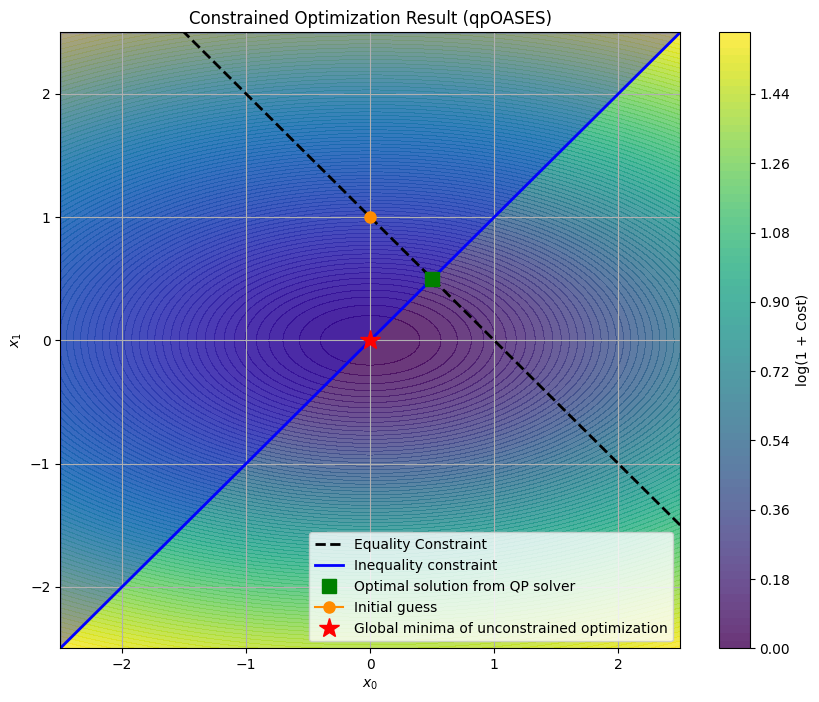

In [11]:
# qpOASES for QP
opt = QPOptimizer()
opt.set_constraints(eq_params=(1, 1, -1), ineq_params=(1, -1, 0))
opt.solve(x_init=[0.0, 1.0])
opt.plot_results()


#### **Example 3.1: Manual Sequential QP Solver Implementation**  

Sequential Quadratic Programming (SQP) is a widely used iterative method for solving NLP problems. The core idea of SQP is to approximate the NLP at each iteration with a quadratic programming (QP) subproblem, which captures the local curvature of the objective and constraints. The solution to this QP subproblem provides a search direction for updating the decision variables.

An SQP algorithm typically follows these steps at each iteration:

1. **Linearize the constraints** $ \boldsymbol{h}(\boldsymbol{x}) $ and $ \boldsymbol{g}(\boldsymbol{x}) $ using first-order Taylor expansions;  
2. **Approximate the Hessian** of the Lagrangian $\Lambda$ (e.g., using exact second-order information or BFGS approximation);  
3. **Solve the resulting QP subproblem** to obtain a search direction $ \boldsymbol{d} $;  
4. **Perform a line search** or trust-region update along $ \boldsymbol{d} $ to update the iterate $ \boldsymbol{x} $;  
5. **Repeat** until convergence criteria are met.

Mathematically, the QP subproblem solved at each iteration takes the form:

$$
\begin{aligned}
\min_{\boldsymbol{d}} \quad & \frac{1}{2} \boldsymbol{d}^\top \boldsymbol{H}_k \boldsymbol{d} + \nabla f(\boldsymbol{x}_k)^\top \boldsymbol{d} \\
\text{s.t.} \quad & \boldsymbol{h}(\boldsymbol{x}_k) + \nabla \boldsymbol{h}(\boldsymbol{x}_k)^\top \boldsymbol{d} = 0, \\
                  & \boldsymbol{g}(\boldsymbol{x}_k) + \nabla \boldsymbol{g}(\boldsymbol{x}_k)^\top \boldsymbol{d} \leq 0,
\end{aligned}
$$

where $ \boldsymbol{H}_k $ is a (possibly approximated) Hessian of the Lagrangian at the current iterate $ \boldsymbol{x}_k $.


In this section, we demonstrate how to manually implement a **Sequential Quadratic Programming (SQP)** solver using CasADi. The solver is built from scratch by explicitly forming the Taylor expansion of the Lagrangian function, updating the Hessian at each iteration, and solving a Quadratic Programming (QP) subproblem using qpOASES, which is natively integrated into CasADi. This implementation gives full control over the optimization process and provides a transparent view of how SQP operates internally. The procedure follows the steps below:

&nbsp;&nbsp;&nbsp;&nbsp;1\) Formulate the nonlinear optimization problem:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & f(\boldsymbol{x}) \\
\text{s.t.} \quad & \boldsymbol{h}(\boldsymbol{x}) = \boldsymbol{0}, \\
                  & \boldsymbol{g}(\boldsymbol{x}) \leq \boldsymbol{0},
\end{aligned}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $ f(\boldsymbol{x}) $ is a nonlinear cost function, $ \boldsymbol{h}(\boldsymbol{x}) $ defines equality constraints, and $ \boldsymbol{g}(\boldsymbol{x}) $ defines inequality constraints.

&nbsp;&nbsp;&nbsp;&nbsp;2\) Build symbolic derivatives and Lagrangi, the `SQPOptimizer` class computes:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  The **gradient** of the objective function,   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  The **Jacobian** of equality and inequality constraints,   

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  The **Lagrangian function**,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  the **gradient and Hessian** of the Lagrangian with respect to $ \boldsymbol{x} $,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  A **merit function** to measure constraint violation and guide line search.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;All symbolic derivatives are precompiled using CasADi’s automatic differentiation.

&nbsp;&nbsp;&nbsp;&nbsp;3\) Construct and solve the following QP subproblem at each iteration\:

$$
\begin{aligned}
\min_{\boldsymbol{d}} \quad & \frac{1}{2} \boldsymbol{d}^\top H_k \boldsymbol{d} + \nabla f(\boldsymbol{x}_k)^\top \boldsymbol{d} \\
\text{s.t.} \quad & A_h \boldsymbol{d} + h(\boldsymbol{x}_k) = 0 \\
                  & A_g \boldsymbol{d} + g(\boldsymbol{x}_k) \leq 0
\end{aligned}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  $ H_k $ is the Hessian of the Lagrangian,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  $ A_h, A_g $ are the Jacobians of the constraints.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;This QP is solved using CasADi’s interface to **qpOASES**. The primal step $ \boldsymbol{d}_k $ and dual multipliers $ \boldsymbol{\lambda}_k $ are extracted from the QP solution.


&nbsp;&nbsp;&nbsp;&nbsp;4\) Perform line search using the Lagrangian. By determining the constraint violation at each step, you can select step sizes that only lead to feasible iterates. In practice, often so-called merit functions are employed, which help to improve convergence especially from infeasible initial guesses. 

&nbsp;&nbsp;&nbsp;&nbsp;5\) Repeat SQP process until one of the following conditions is met:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  The primal step $ \|\boldsymbol{d}_k\| $ is sufficiently small,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  The KKT residual is below tolerance,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  A maximum number of iterations is reached,

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;•  The QP subproblem becomes infeasible.



In [12]:
class SQPOptimizer:
    def __init__(self, f_func, eq_func=None, ineq_func=None, max_iter=50, tol=1e-6, only_feasible_steps=False, verbose=False):
        self.f_func = f_func
        self.eq_func = eq_func
        self.ineq_func = ineq_func
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.trace = []
        self.only_feasible_steps = only_feasible_steps

        self.x_dim = f_func.size_in(0)[0]
        self._setup_derivatives()

    def _setup_derivatives(self):
        x = ca.MX.sym('x', self.x_dim)
        self.grad_f = ca.Function('grad_f', [x], [ca.gradient(self.f_func(x), x)])

        if self.eq_func is not None:
            self.grad_eq = ca.Function('grad_eq', [x], [ca.jacobian(self.eq_func(x), x)])
        if self.ineq_func is not None:
            self.grad_ineq = ca.Function('grad_ineq', [x], [ca.jacobian(self.ineq_func(x), x)])

        lambda_dim = 0
        if self.eq_func is not None:
            lambda_dim += self.eq_func(x).size1()
        if self.ineq_func is not None:
            lambda_dim += self.ineq_func(x).size1()

        lmbda = ca.MX.sym('lmbda', lambda_dim)
        L = self.f_func(x)
        idx = 0
        self.num_equality_constraints = 0
        self.num_inequality_constraints = 0

        if self.eq_func is not None:
            eq_val = self.eq_func(x)
            self.num_equality_constraints = eq_val.size1()
            for i in range(self.num_equality_constraints):
                L += lmbda[idx] * eq_val[i]
                idx += 1
            
        if self.ineq_func is not None:
            ineq_val = self.ineq_func(x)
            self.num_inequality_constraints = ineq_val.size1()
            for i in range(self.num_inequality_constraints):
                L += lmbda[idx] * ineq_val[i]
                idx += 1

        self.lagrangian = ca.Function('lagrangian', [x, lmbda], [L])
        self.grad_lagrangian = ca.Function('grad_lagrangian', [x, lmbda], [ca.gradient(L, x)])
        self.hess_L = ca.Function('hess_L', [x, lmbda], [ca.hessian(L, x)[0]])
    
        self.constraint_violation = ca.Function('constr_violation', [x], 
                                              [self._calculate_constraint_violation(x)])

    def _calculate_constraint_violation(self, x):
        """Calculate the constraint violation for merit function."""        
        violations = []
        
        if self.eq_func is not None:
            eq_val = self.eq_func(x)
            for i in range(eq_val.size1()):
                violations.append(ca.fabs(eq_val[i]))
                
        if self.ineq_func is not None:
            ineq_val = self.ineq_func(x)
            for i in range(ineq_val.size1()):
                violations.append(ca.fmax(0, ineq_val[i]))
                
        if violations:
            return ca.sum1(ca.vertcat(*violations))
        else:
            return ca.MX(0)

    def solve(self, x0):

        start_time = time.time()

        x_k = np.array(x0).flatten()
        lambda_k = np.zeros(self.num_equality_constraints + self.num_inequality_constraints)
        # Initialize lambda_k with a positive value for inequality constraints
        lambda_k[self.num_equality_constraints:] = 1.0
        
        H_k = np.eye(self.x_dim)

        for iteration in range(self.max_iter):
            self.trace.append(x_k.copy())

            grad_f_k = np.array(self.grad_f(x_k).full()).flatten()

            eq_val_k, grad_eq_k = None, None
            ineq_val_k, grad_ineq_k = None, None
            if self.eq_func is not None:
                eq_val_k = np.array(self.eq_func(x_k).full()).flatten()
                grad_eq_k = np.array(self.grad_eq(x_k).full())
            if self.ineq_func is not None:
                ineq_val_k = np.array(self.ineq_func(x_k).full()).flatten()
                grad_ineq_k = np.array(self.grad_ineq(x_k).full())

            H_k = np.array(self.hess_L(x_k, lambda_k).full())
            # Make sure H_k is symmetric, it should be theoretically but does not have to be numerically
            H_k = (H_k + H_k.T) / 2

            eigvals = np.linalg.eigvalsh(H_k)
            min_eig = np.min(eigvals)
            if min_eig <= 1e-6:
                H_k += (abs(min_eig) + 1e-4) * np.eye(H_k.shape[0])

            # Solve QP
            success, d_k, multipliers = self._solve_qp(
                H_k,
                grad_f_k,
                grad_eq_k,
                eq_val_k if eq_val_k is not None else None,
                grad_ineq_k,
                ineq_val_k if ineq_val_k is not None else None
            )

            if not success:
                if self.verbose:
                    print(f"[Iter {iteration}] QP solver failed, early stop.")
                break

            if np.linalg.norm(d_k) < self.tol:
                self.trace.append(x_k + d_k[:self.x_dim])
                if self.verbose:
                    print(f"[Iter {iteration}] Converged, step norm={np.linalg.norm(d_k):.2e}")
                break

            # Line search (backtracking)
            alpha = 0.9
            beta = 0.5
            c1 = 1e-4
            lagrangian_current = self.lagrangian(x_k, lambda_k).full().flatten()[0]
            lagrangian_grad_current = np.array(self.grad_lagrangian(x_k, lambda_k).full()).flatten()

            while True:
                x_trial = x_k + alpha * d_k
                lambda_trial = multipliers
                lagrangian_trial = self.lagrangian(x_trial, lambda_trial).full().flatten()[0]

                if self.constraint_violation(x_trial).full().flatten()[0] <= 1e-6 or not self.only_feasible_steps:
                    if lagrangian_trial <= lagrangian_current + c1 * alpha * np.dot(lagrangian_grad_current, d_k):
                        break
                alpha *= beta
                if alpha < 1e-8:
                    break

            x_next = x_k + alpha * d_k
            # Use the multipliers from the QP solver
            lambda_next = multipliers

            x_k = x_next
            lambda_k = lambda_next
            
            if self.verbose:
                print(f"[Iter {iteration}] Cost: {lagrangian_current:.6f}, alpha={alpha:.3f}, step norm={np.linalg.norm(d_k):.2e}")

            print(f"Total computation time: {time.time() - start_time} sec.")

        return x_k

    def _solve_qp(self, H, f, A_eq, b_eq, A_ineq, b_ineq):
        x = ca.MX.sym('x', H.shape[1])
        f = f.reshape((1, -1))
        cost = 0.5 * ca.mtimes([x.T, H, x]) + ca.mtimes(f, x)

        constraints = []
        lbg = []
        ubg = []

        if A_eq is not None and A_eq.shape[0] > 0:
            constraints.append(ca.mtimes(A_eq, x) + b_eq)
            lbg.append(np.zeros(A_eq.shape[0]))
            ubg.append(np.zeros(A_eq.shape[0]))

        if A_ineq is not None and A_ineq.shape[0] > 0:
            constraints.append(ca.mtimes(A_ineq, x) + b_ineq)
            ubg.append(np.zeros(A_ineq.shape[0]))
            lbg.append(np.full(A_ineq.shape[0], -np.inf))

        if constraints:
            g = ca.vertcat(*constraints)
            lbg = np.concatenate(lbg)
            ubg = np.concatenate(ubg)
        else:
            g = ca.MX()
            lbg = np.array([])
            ubg = np.array([])

        qp = {'x': x, 'f': cost, 'g': g}
        solver = ca.qpsol('solver', 'qpoases', qp, {'error_on_fail': False})
        sol = solver(lbg=lbg, ubg=ubg)

        stats = solver.stats()
        success = not bool(stats['return_status'] == 'Infeasible_Problem_Detected')

        return success, np.array(sol['x'].full()).flatten(), np.array(sol['lam_g'].full()).flatten()

    def plot_trajectory(self, global_minima=None):
        x_max, x_min, y_max, y_min = 2.5, -2.5, 2.5, -2.5
        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.f_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')
 
        # Equality constraint
        if self.eq_func is not None:
            eq_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    eq_vals[i, j] = self.eq_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, eq_vals, levels=[0], colors='k', linewidths=2, linestyles='--')
            ax.plot([], [], color='black', linestyle='--', linewidth=2, label='Equality constraint')

        # Inequality constraint
        if self.ineq_func is not None:
            ineq_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    ineq_vals[i, j] = self.ineq_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, ineq_vals, levels=[0], colors='b', linewidths=2)
            ax.plot([], [], color='blue', linewidth=2, label='Inequality constraint')
            ax.contourf(X, Y, ineq_vals, levels=[-np.inf, 0], colors='blue', alpha=0.3)

        if self.trace:
            traj = np.array(self.trace)
            ax.plot(traj[:, 0], traj[:, 1], 'd-', color='orange', label='SQP Trajectory')
            ax.plot(traj[-1, 0], traj[-1, 1], 'gs', markersize=10, label='Optimal solution from SQP solver', zorder=11)
            ax.plot(traj[0, 0], traj[0, 1], color='darkorange', marker='o', markersize=8, label='Initial guess', zorder=11)

        if global_minima is not None:
            ax.plot(global_minima[0], global_minima[1], '*', color='red', markersize=15, label='Global minima of unconstrained optimization')

        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("SQP Optimization Trajectory")
        ax.grid(True)
        ax.legend(loc='lower left')
        plt.show()


<br>

##### **Example 3.2: Using Implemented SQP Solver for Nonlinear Programming**

1\) Specify the objective function as follows;

- Quadratic function: $f(\boldsymbol{x}) = \frac{1}{8} x_0^2 + \frac{1}{2} x_1^2$

2\) Specify the nonlinear constraints as follows; 

- Equality constraint: None  

- Inequality constraint: $h(\boldsymbol{x}) = {(x_0 - 1)}^2 + 3 {(x_1 - 1.5)}^2 - 1$ (Ellipsoid) 

3\) Instantiate the class `SQPOptimizer` with pre-defined $f(\boldsymbol{x})$, $g(\boldsymbol{x})$ and $h(\boldsymbol{x})$;

4\) Set the initial guess as $[1.5 \quad 1.5]$ and call function `solve()` to solve the NLP problem;

5\) Call function `plot_results()` to visualize the results;


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.


qpOASES -- An Implementation of the Online Active Set Strategy.
Copyright (C) 2007-2015 by Hans Joachim Ferreau, Andreas Potschka,
Christian Kirches et al. All rights reserved.

qpOASES is distributed under the terms of the 
GNU Lesser General Public License 2.1 in the hope that it will be 
useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. 
See the GNU Lesser General Public License for more details.



####################   qpOASES  --  QP

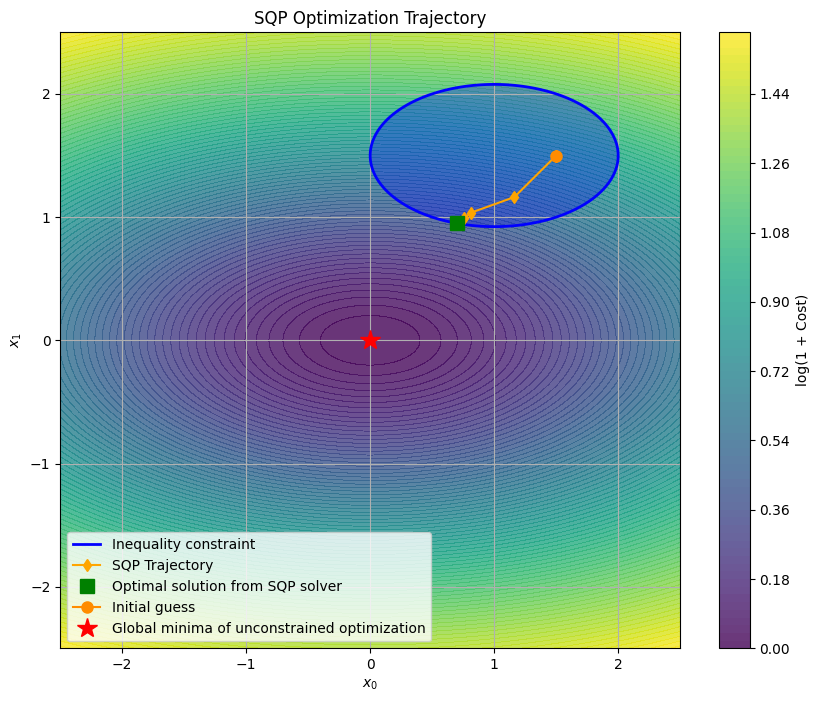

In [13]:
# Define symbols
x = ca.MX.sym('x', 2)

# Objective: simple quadratic
f = ca.Function("f", [x], [0.5 * (x[0]**2 / 4 + x[1]**2)])
# Inequality constraint: ellipsoid
g = ca.Function("g", [x], [(x[0] - 1)**2 + (x[1] - 1.5)**2 * 3 - 1])  # g(x) <= 0
# Equality constraint: None
h = None  

# Instantiate solver
sqp_solver = SQPOptimizer(
    f_func=f,
    eq_func=h,
    ineq_func=g,
    max_iter=50,
    tol=1e-6,
    only_feasible_steps=True,  # if True, only feasible step sizes are accepted
    verbose=True 
)

# Initial point
x_init = np.array([1.5, 1.5])

# Solve
sol = sqp_solver.solve(x_init)

print("Optimal Solution Found:", sol)

# Plot
sqp_solver.plot_trajectory(global_minima=np.array([0.0, 0.0]))


<br>

##### **Example 3.3: Configuring Built-in SQP Solvers for NLP**

In the previous section, we introduced the SQP method and provided a custom implementation that manually performs linearizations, constructs QP subproblems, and iteratively updates the solution. While such an implementation is valuable for understanding the inner workings of SQP and customizing its behavior, in practical applications it is often more convenient to leverage existing optimization libraries.

Modern numerical tools like **CasADi** provide an implementation of SQP through the built-in `"sqpmethod"` solver, which automates the above process. The user only needs to provide the nonlinear objective and constraint functions, and CasADi internally handles the linearizations, QP construction, and iterative updates.

The configuration of a SQP solver is similar to the QP solver, which follows the steps:

&nbsp;&nbsp;&nbsp;&nbsp;**1) Formulate the NLP problem.** The standard form of a generic nonlinear programming (NLP) problem is:

$$
\begin{aligned}
\min_{\boldsymbol{x}} \quad & f(\boldsymbol{x}) \\
\text{s.t.} \quad & \boldsymbol{h}(\boldsymbol{x}) = \boldsymbol{0}, \\
                  & \boldsymbol{g}(\boldsymbol{x}) \leq \boldsymbol{0},
\end{aligned}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $ f(\boldsymbol{x}) $ is a nonlinear cost function, $ \boldsymbol{h}(\boldsymbol{x}) $ defines equality constraints, and $ \boldsymbol{g}(\boldsymbol{x}) $ defines inequality constraints.

&nbsp;&nbsp;&nbsp;&nbsp;**2) Define the NLP structure in CasADi.** To pass the NLP into CasADi, you need to define a dictionary:

$$
\texttt{nlp = \{x: } \boldsymbol{x} \texttt{, f: } f(\boldsymbol{x}) \texttt{, g: } \boldsymbol{c}(\boldsymbol{x}) \texttt{\}},
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $ \boldsymbol{x} \in \mathbb{R}^n $ is the optimization variable, $ f(\boldsymbol{x}) $ is the cost function, and $ \boldsymbol{c}(\boldsymbol{x}) $ combines all constraints:

$$
\boldsymbol{c}(\boldsymbol{x}) =
\begin{bmatrix}
\boldsymbol{h}(\boldsymbol{x}) \\
\boldsymbol{g}(\boldsymbol{x})
\end{bmatrix}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The corresponding lower and upper bounds are:

$$
\boldsymbol{l}_c =
\begin{bmatrix}
\boldsymbol{0} \\
-\infty
\end{bmatrix}, \quad
\boldsymbol{u}_c =
\begin{bmatrix}
\boldsymbol{0} \\
\boldsymbol{0}
\end{bmatrix}
$$


&nbsp;&nbsp;&nbsp;&nbsp;**3) Configure and call the solver.** Create the SQP solver by specifying the backend as `"sqpmethod"`:

$$
\texttt{solver = nlpsol("solver", "sqpmethod", nlp)}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Then solve the problem with an initial guess and the constraint bounds:

$$
\texttt{sol = solver(x0, lbg = } \boldsymbol{l}_c \texttt{, ubg = } \boldsymbol{u}_c \texttt{)}
$$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The optimal solution can be extracted from `sol['x']`.

*Note that: for more detail on NLP solvers in CasADi, check out this material https://web.casadi.org/docs/#nonlinear-programming.*  

In [14]:
class SQPOptimizer:
    def __init__(self, objective_func, eq_func=None, ineq_func=None, global_minima=None):
        self.objective_func = objective_func
        self.eq_func = eq_func
        self.ineq_func = ineq_func
        self.global_minima = np.array(global_minima) if global_minima is not None else None

        self.x_dim = self.objective_func.size_in(0)[0]
        self.x_init = None
        self.x_end = None
        self._setup_nlp()

    def _setup_nlp(self):
        x = ca.MX.sym('x', self.x_dim)
        cost = self.objective_func(x)

        constraints = []
        lbg = []
        ubg = []

        if self.eq_func is not None:
            # eq_func(x) = 0
            eq_expr = self.eq_func(x)
            constraints.append(eq_expr)
            lbg.append(np.zeros(eq_expr.shape[0]))
            ubg.append(np.zeros(eq_expr.shape[0]))

        if self.ineq_func is not None:
            # ineq_func(x) <= 0
            ineq_expr = self.ineq_func(x)
            constraints.append(ineq_expr)
            lbg.append(-np.inf * np.ones(ineq_expr.shape[0]))
            ubg.append(np.zeros(ineq_expr.shape[0]))

        if constraints:
            g = ca.vertcat(*constraints)
            self.lbg = np.concatenate(lbg)
            self.ubg = np.concatenate(ubg)
        else:
            g = ca.MX()
            self.lbg = np.array([])
            self.ubg = np.array([])

        self.x_sym = x
        self.nlp = {'x': x, 'f': cost, 'g': g}
        self.solver = ca.nlpsol('solver', 'sqpmethod', self.nlp, {'qpsol': 'qrqp', 'print_time': 0})

    def solve(self, x_init):

        start_time = time.time()

        x_init = np.array(x_init).flatten()
        self.x_init = x_init.copy()

        sol = self.solver(x0=x_init, lbg=self.lbg, ubg=self.ubg)
        self.x_end = np.array(sol['x'].full()).flatten()

        print(f"Total computation time: {time.time() - start_time} sec.")

        return self.x_end
    
    def plot_results(self):
        x_max, x_min, y_max, y_min = 2.5, -2.5, 2.5, -2.5
        x = np.linspace(x_min, x_max, 400)
        y = np.linspace(y_min, y_max, 400)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)

        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.objective_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]

        Z_log = np.log1p(Z)  # log(1 + Z), to highlight the difference

        fig, ax = plt.subplots(figsize=(10, 8))

        # Contour of objective function
        CS = ax.contourf(X, Y, Z_log, levels=100, cmap=cm.viridis, alpha=0.8)
        cbar = plt.colorbar(CS, ax=ax)
        cbar.set_label('log(1 + Cost)')

        # Inequality constraint
        if self.ineq_func is not None:
            G_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    G_vals[i, j] = self.ineq_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, G_vals, levels=[0], colors='b', linewidths=2)
            ax.plot([], [], color='blue', linewidth=2, label='Inequality constraint')
            ax.contourf(X, Y, G_vals, levels=[-np.inf, 0], colors='blue', alpha=0.3)

        # Equality constraint
        if self.eq_func is not None:
            H_vals = np.zeros_like(X)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    H_vals[i, j] = self.eq_func(np.array([X[i, j], Y[i, j]])).full().flatten()[0]
            ax.contour(X, Y, H_vals, levels=[0], colors='k', linewidths=2, linestyles='--')
            ax.plot([], [], color='black', linestyle='--', linewidth=2, label='Equality constraint')

        # Plot optimal point
        if self.x_end is not None:
            ax.plot(self.x_end[0], self.x_end[1], 'gs', markersize=10, label='Optimal solution from SQP solver', zorder=11)

        # Plot known global minimum
        if self.global_minima is not None:
            ax.plot(self.global_minima[0], self.global_minima[1], '*', color='red', markersize=15, label='Global minima of unconstrained optimization')

        ax.plot(self.x_init[0], self.x_init[1], color='darkorange', marker='o', markersize=8, label='Initial guess', zorder=11)

        ax.set_xlim([x_min, x_max])
        ax.set_ylim([y_min, y_max])
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.set_title("SQP (sqpmethod) Optimization Result")
        ax.grid(True)
        ax.legend(loc='lower left')
        plt.show()




<br>

##### **Example 3.4: Using Built-in SQP Solver for NLP**

1\) Specify the objective function as follows;

- Quadratic function: $f(\boldsymbol{x}) = \frac{1}{8} x_0^2 + \frac{1}{2} x_1^2$

2\) Specify the nonlinear constraints as follows; 

- Equality constraint: None (can be considered as a special case of inequality constraint)  

- Inequality constraint: $g(\boldsymbol{x}) = {(x_0 - 1)}^2 + 3{(x_1 - 1.5)}^2 - 1$ (Ellipsoid)   

3\) Instantiate the class `SQPOptimizer` with pre-defined $f(\boldsymbol{x})$, $g(\boldsymbol{x})$ and $h(\boldsymbol{x})$;

4\) Set the initial guess as $[1.5 \quad 1.5]$ and call function `solve()` to solve the NLP problem;

5\) Call function `plot_results()` to visualize the results;

-------------------------------------------
This is casadi::QRQP
Number of variables:                               2
Number of constraints:                             1
Number of nonzeros in H:                           2
Number of nonzeros in A:                           2
Number of nonzeros in KKT:                         7
Number of nonzeros in QR(V):                       5
Number of nonzeros in QR(R):                       6
-------------------------------------------
This is casadi::Sqpmethod.
Using exact Hessian
Number of variables:                               2
Number of constraints:                             1
Number of nonzeros in constraint Jacobian:         2
Number of nonzeros in Lagrangian Hessian:          2

iter      objective    inf_pr    inf_du     ||d||  lg(rg) ls    info
   0   1.406250e+00  0.00e+00  1.50e+00  0.00e+00       -  0  - 
 Iter  Sing        fk      |pr|   con      |du|   var     min_R   con  last_tau  Note
    0     0         0         0    -1   

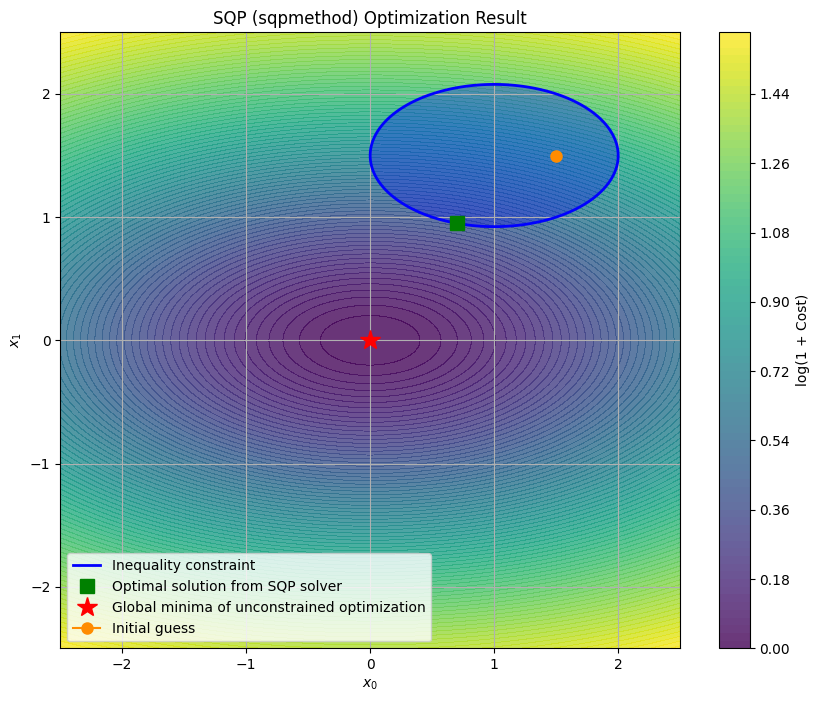

In [15]:
x = ca.MX.sym('x', 2)

# Objective: simple quadratic
f = ca.Function("f", [x], [0.5 * (x[0]**2 / 4 + x[1]**2)])
# Inequality constraint: ellipsoid
g = ca.Function("g", [x], [(x[0] - 1)**2 + (x[1] - 1.5)**2 * 3 - 1])  # g(x) <= 0
# Equality constraint: None
h = None  

sqp_solver = SQPOptimizer(
    objective_func=f,
    eq_func=h,
    ineq_func=g,
    global_minima=[0, 0]
)

x_init = np.array([1.5, 1.5])

sol = sqp_solver.solve(x_init)
sqp_solver.plot_results()


----

#### **Conclusion**

In this chapter, we discussed many importants aspects of solving various optimization problems. Through various examples and algorithmic components, we highlighted that the effectiveness of a solver is highly sensitive to:

- How the problem is formulated (e.g., cost structure, constraints)

- The choice of optimization algorithm

- The tuning of solver parameters

These aspects directly impact convergence speed, robustness, and solution quality.

In particular, we introduced the Sequential Quadratic Programming (SQP) framework, which plays a central role in solving constrained nonlinear optimal control problems. SQP will reappear as the core optimization strategy in both:

- iterative Linear Quadratic Regulator (iLQR) in Chapter 4

- nonlinear Model Predictive Control (NMPC) in Chapter 5

These methods build upon the optimization foundations laid in this chapter to address increasingly complex and realistic control tasks.